# <h1><center><center><h1>

# <h1><center>Unified CNN Approach for Multi-Class MRI Brain Tumor Classification<center><h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Brain Tumor MRI Dataset

/content/drive/MyDrive/Brain Tumor MRI Dataset


# Packages

In [ ]:
import os
import random
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
import warnings
warnings.filterwarnings("ignore")

let's see information about data  

In [ ]:
print('Training:\n')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/glioma'))
print(Fore.BLUE + f'glioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/meningioma'))
print(Fore.BLUE + f'meningioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/notumor'))
print(Fore.BLUE + f'notumor: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training/pituitary'))
print(Fore.BLUE + f'pituitary: {len(files)}\n')

print(Fore.WHITE + 'Testing:\n')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/glioma'))
print(Fore.BLUE + f'glioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/meningioma'))
print(Fore.BLUE + f'meningioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/notumor'))
print(Fore.BLUE + f'notumor: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing/pituitary'))
print(Fore.BLUE + f'pituitary: {len(files)}\n')


Training:

glioma: 1321
meningioma: 1339
notumor: 1595
pituitary: 1457

Testing:

glioma: 300
meningioma: 306
notumor: 405
pituitary: 300



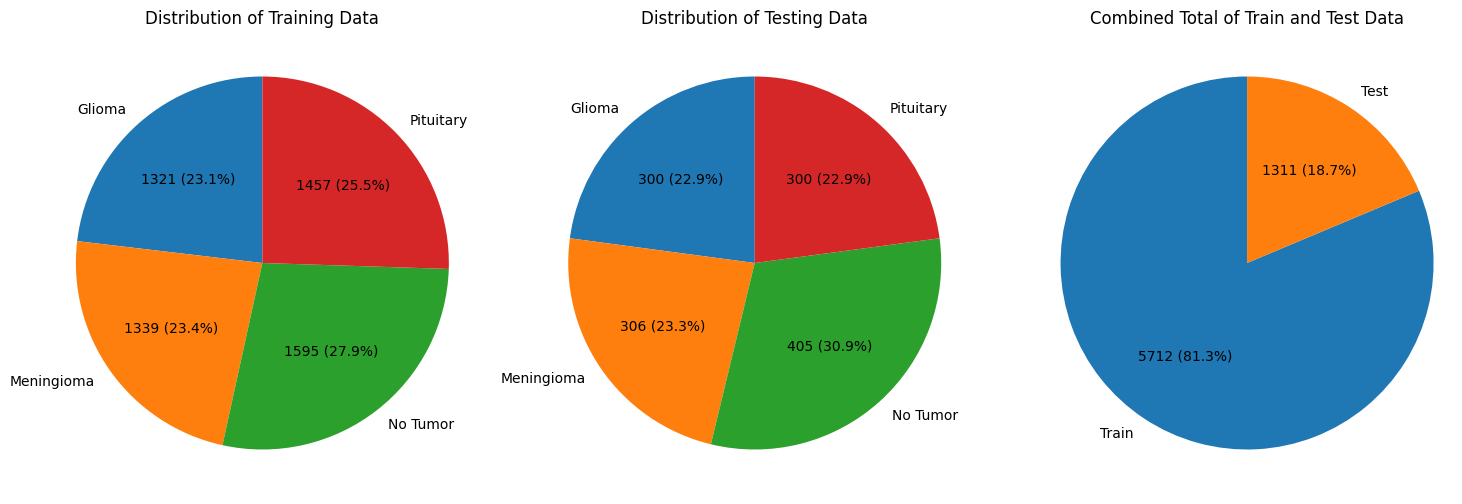

In [ ]:
# Data for training and testing
train_counts = [1321, 1339, 1595, 1457]
test_counts = [300, 306, 405, 300]
labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

total_train = sum(train_counts)
total_test = sum(test_counts)
total_labels = ['Train', 'Test']
total_counts = [total_train, total_test]

# Custom function for autopct to ensure accurate numbers
def custom_autopct(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{absolute} ({pct:.1f}%)"

def plot_pie_chart(data, labels, title, ax):
    ax.pie(data, labels=labels, autopct=lambda pct: custom_autopct(pct, data), startangle=90)
    ax.axis('equal')
    ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_pie_chart(train_counts, labels, "Distribution of Training Data", axs[0])
plot_pie_chart(test_counts, labels, "Distribution of Testing Data", axs[1])
plot_pie_chart(total_counts, total_labels, "Combined Total of Train and Test Data", axs[2])

plt.show()


## Here we create the Dataset and make preprocessing on it  and Split it into Training, Validation and Testing Sets:

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dataset = image_dataset_from_directory('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.15,
                                             subset='training',
                                             label_mode = 'categorical',
                                             seed=42)

validation_dataset = image_dataset_from_directory('/content/drive/MyDrive/Brain Tumor MRI Dataset/Training',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.15,
                                             subset='validation',
                                             label_mode = 'categorical',
                                             seed=42)

test_dataset = image_dataset_from_directory('/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing',
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode = 'categorical',
                                            )
# prefetch the train_dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5712 files belonging to 4 classes.
Using 4856 files for training.
Found 5712 files belonging to 4 classes.
Using 856 files for validation.
Found 1311 files belonging to 4 classes.


In [ ]:
# this cell to enable me to evaluate the model in confusion matrix
y_true = np.concatenate([ y for _ , y in test_dataset] , axis = 0)

let's see the images of our data

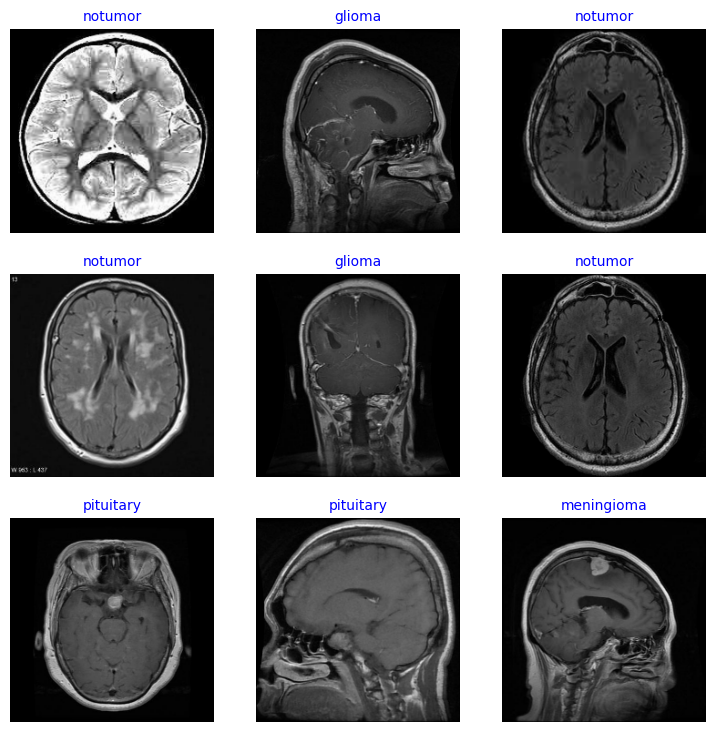

In [ ]:
class_names = test_dataset.class_names
plt.figure(figsize=(9, 9))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])] , c = 'blue' , size = 10)
    plt.axis("off")


shuffle is done

<hr>

# Models

In [ ]:
# Hyperparameters
from tensorflow.keras.optimizers import legacy

IMG_SHAPE = IMG_SIZE + (3,)
LOSS = keras.losses.CategoricalCrossentropy()
OPTIMIZER = legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
SEED = 42

In [ ]:
# callbacks for the models
def get_callbacks (model_name):
  callbacks = []
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= f'model.{model_name}.h5', monitor = 'val_loss', verbose = 1 ,
                                                    mode = 'min', save_best_only=True, save_freq='epoch')
  callbacks.append(checkpoint)
  rlr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.2, patience=5, mode='auto', min_lr=0.0)
  callbacks.append(rlr)
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)
  callbacks.append(earlystop)

  return callbacks

In [ ]:
# function for plot resultes

def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 9], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()

# for make dataframe for all model
model_name= ['My_model','DenseNet121','VGG16','ResNet50V2','MobileNetV2','EfficientNetV2S','Xception']
CategoricalAccuracy= []
losses= []


# <h2 style = "color: #35454F">My_model   </h2>

In [ ]:
model = Sequential([
    tfl.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(64, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(128, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(256, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Flatten(),
    tfl.Dense(512, activation='relu'),
    tfl.Dropout(0.5),
    tfl.Dense(4, activation='softmax')
])

model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('my_model')
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 3.9105 - categorical_accuracy: 0.6670
Epoch 1: val_loss improved from inf to 0.56560, saving model to model.my_model.h5
152/152 [==============================] - 390s 3s/step - loss: 3.9105 - categorical_accuracy: 0.6670 - val_loss: 0.5656 - val_categorical_accuracy: 0.7979 - lr: 0.0010
Epoch 2/10
151/152 [============================>.] - ETA: 0s - loss: 0.4845 - categorical_accuracy: 0.8309
Epoch 2: val_loss improved from 0.56560 to 0.38413, saving model to model.my_model.h5
152/152 [==============================] - 30s 189ms/step - loss: 0.4835 - categorical_accuracy: 0.8313 - val_loss: 0.3841 - val_categorical_accuracy: 0.8773 - lr: 0.0010
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.3541 - categorical_accuracy: 0.8775
Epoch 3: val_loss improved from 0.38413 to 0.34777, saving model to model.my_model.h5
152/152 [==============================] - 27s 172ms/step - loss: 0.3541 - categor

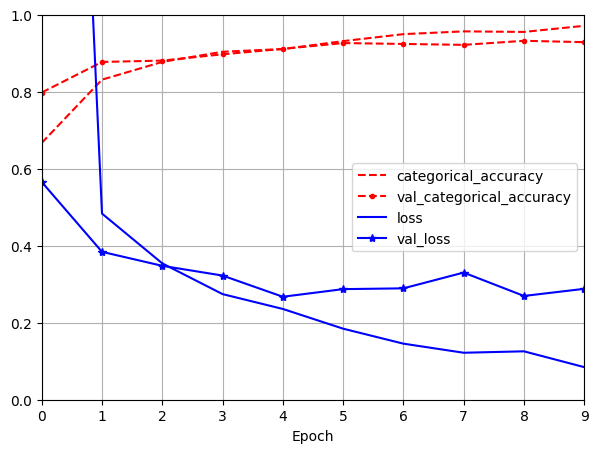

In [ ]:
plot()

In [ ]:
loss, categorical_accuracy = model.evaluate(test_dataset)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 [==============================] - 6s 134ms/step - loss: 0.2686 - categorical_accuracy: 0.9245


# <h2 style = "color: #35454F">DenseNet </h2>

In [ ]:
from tensorflow.keras.applications import DenseNet121

dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
dense_model.trainable = False

x = dense_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=dense_model.input, outputs=predictions)

model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy() , keras.metrics.Recall()])

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [ ]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.densenet import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_densenet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_densenet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_densenet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


In [ ]:
callbacks = get_callbacks('DenseNet121')

history = model.fit(
    train_dataset_densenet,
    epochs=10,
    validation_data=validation_dataset_densenet,
    callbacks=callbacks
)

Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 0.4311 - categorical_accuracy: 0.8404 - recall: 0.8081
Epoch 1: val_loss improved from inf to 0.27648, saving model to model.DenseNet121.h5
152/152 [==============================] - 47s 236ms/step - loss: 0.4311 - categorical_accuracy: 0.8404 - recall: 0.8081 - val_loss: 0.2765 - val_categorical_accuracy: 0.9077 - val_recall: 0.8914 - lr: 2.0000e-04
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.2522 - categorical_accuracy: 0.9057 - recall: 0.8933
Epoch 2: val_loss improved from 0.27648 to 0.24778, saving model to model.DenseNet121.h5
152/152 [==============================] - 35s 223ms/step - loss: 0.2522 - categorical_accuracy: 0.9057 - recall: 0.8933 - val_loss: 0.2478 - val_categorical_accuracy: 0.9194 - val_recall: 0.9042 - lr: 2.0000e-04
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.2117 - categorical_accuracy: 0.9257 - recall: 0.9170
Epoch 3: val_loss improve

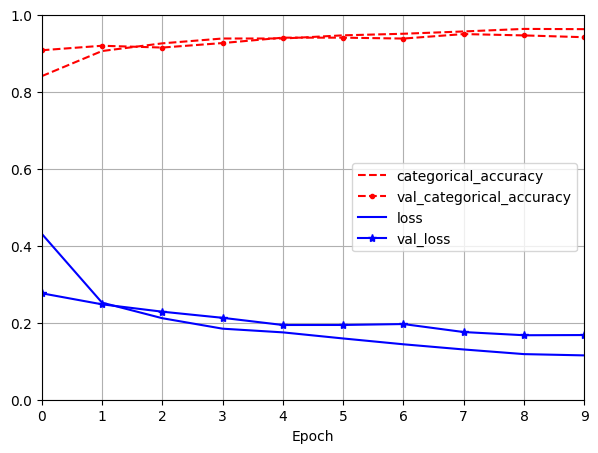

In [ ]:
plot()

In [ ]:
loss, categorical_accuracy, recall = model.evaluate(test_dataset_densenet)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 [==============================] - 11s 269ms/step - loss: 0.2134 - categorical_accuracy: 0.9245 - recall: 0.9176


# <h2 style = "color: #35454F">VGG-16 </h2>

In [ ]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_vgg16 = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_vgg16 = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_vgg16 = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import VGG16

VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
VGG16_model.trainable = False

x = VGG16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=VGG16_model.input, outputs=predictions)
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('VGG16')
history = model.fit(
    train_dataset_vgg16,
    epochs=10,
    validation_data=validation_dataset_vgg16,
    callbacks=callbacks
)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 0.6648 - categorical_accuracy: 0.8116
Epoch 1: val_loss improved from inf to 0.32420, saving model to model.VGG16.h5
152/152 [==============================] - 50s 275ms/step - loss: 0.6648 - categorical_accuracy: 0.8116 - val_loss: 0.3242 - val_categorical_accuracy: 0.8633 - lr: 2.0000e-04
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.2224 - categorical_accuracy: 0.9203
Epoch 2: val_loss improved from 0.32420 to 0.24843, saving model to model.VGG16.h5
152/152 [==============================] - 41s 265ms/step - loss: 0.2224 - categorical_accuracy: 0.9203 - val_loss: 0.2484 - val_categorical_accuracy: 0.9007 - lr: 2.0000e-04
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.1519 - categorical_accuracy: 0.9444
Epoch 3: val_loss improved from 0.24843 to 0.22849, saving model to model.VGG16.h5
152/152 [=======

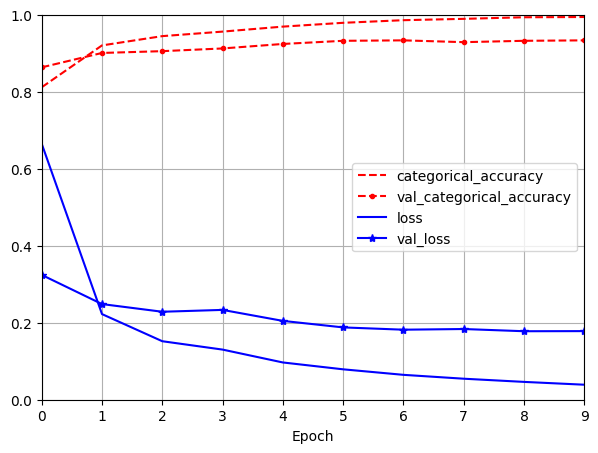

In [ ]:
plot()

In [ ]:
loss, categorical_accuracy = model.evaluate(test_dataset_vgg16)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 [==============================] - 14s 342ms/step - loss: 0.1653 - categorical_accuracy: 0.9481


# <h2 style = "color: #35454F">ResNet50V2 </h2>

In [ ]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.resnet_v2 import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_resnet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_resnet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_resnet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import ResNet50V2
ResNet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
ResNet_model.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=ResNet_model.input, outputs=predictions)
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('ResNet50V2')
history = model.fit(
    train_dataset_resnet,
    epochs=10,
    validation_data=validation_dataset_resnet,
    callbacks=callbacks
)

94668760/94668760 [==============================] - 0s 0us/step
Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 0.4042 - categorical_accuracy: 0.8521
Epoch 1: val_loss improved from inf to 0.25964, saving model to model.ResNet50V2.h5
152/152 [==============================] - 34s 182ms/step - loss: 0.4042 - categorical_accuracy: 0.8521 - val_loss: 0.2596 - val_categorical_accuracy: 0.9065 - lr: 2.0000e-04
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.1798 - categorical_accuracy: 0.9372
Epoch 2: val_loss improved from 0.25964 to 0.22211, saving model to model.ResNet50V2.h5
152/152 [==============================] - 40s 257ms/step - loss: 0.1798 - categorical_accuracy: 0.9372 - val_loss: 0.2221 - val_categorical_accuracy: 0.9217 - lr: 2.0000e-04
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.1224 - categorical_accuracy: 0.9590
Epoch 3: val_loss improved from 0.22211 to 0.20794, saving model to model.ResNet50V2.h5
1

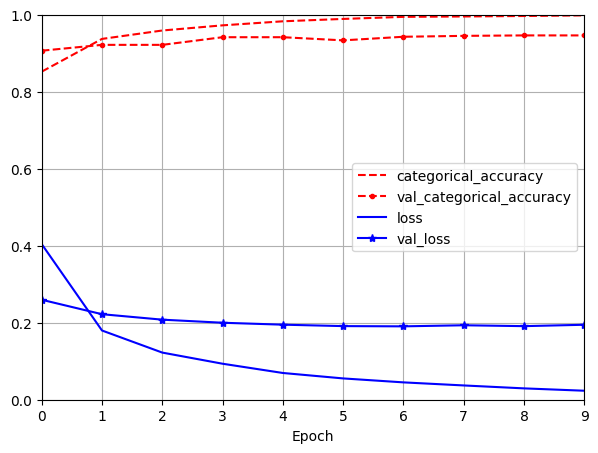

In [ ]:
plot()

In [ ]:
loss, categorical_accuracy = model.evaluate(test_dataset_resnet)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 [==============================] - 7s 166ms/step - loss: 0.1798 - categorical_accuracy: 0.9504


# <h2 style = "color: #35454F">MobileNetV2  </h2>

In [ ]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_mobilenet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_mobilenet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_mobilenet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import MobileNetV2
MobileNet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
MobileNet_model.trainable = False

x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=MobileNet_model.input, outputs=predictions)
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('MobileNetV2')
history = model.fit(
    train_dataset_mobilenet,
    epochs=10,
    validation_data=validation_dataset_mobilenet,
    callbacks=callbacks
)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 0.3970 - categorical_accuracy: 0.8528
Epoch 1: val_loss improved from inf to 0.26339, saving model to model.MobileNetV2.h5
152/152 [==============================] - 31s 172ms/step - loss: 0.3970 - categorical_accuracy: 0.8528 - val_loss: 0.2634 - val_categorical_accuracy: 0.8972 - lr: 2.0000e-04
Epoch 2/10
151/152 [============================>.] - ETA: 0s - loss: 0.2028 - categorical_accuracy: 0.9243
Epoch 2: val_loss improved from 0.26339 to 0.21844, saving model to model.MobileNetV2.h5
152/152 [==============================] - 29s 184ms/step - loss: 0.2024 - categorical_accuracy: 0.9244 - val_loss: 0.2184 - val_categorical_accuracy: 0.9171 - lr: 2.0000e-04
Epoch 3/10
151/152 [============================>.] - ETA: 0s - loss: 0.1477 - categorical_accuracy: 0.9487
Epoch 3: val_loss improved from 0.21844 to 0.20252, saving model to model.MobileNetV2.h5


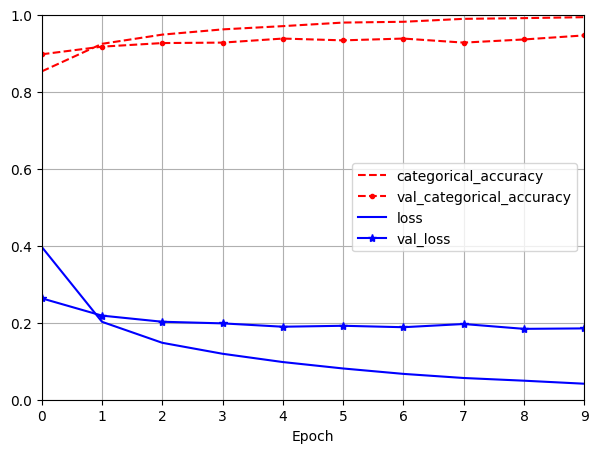

In [ ]:
plot()

In [ ]:
loss, categorical_accuracy = model.evaluate(test_dataset_mobilenet)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 [==============================] - 7s 158ms/step - loss: 0.1874 - categorical_accuracy: 0.9375


# <h2 style = "color: #35454F">EfficientNetV2S  </h2>

In [ ]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_efficientnet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_efficientnet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_efficientnet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import EfficientNetV2S
EfficientNet_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
EfficientNet_model.trainable = False

x = EfficientNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=EfficientNet_model.input, outputs=predictions)
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('EfficientNetV2S')
history = model.fit(
    train_dataset_efficientnet,
    epochs=10,
    validation_data=validation_dataset_efficientnet,
    callbacks=callbacks
)

82420632/82420632 [==============================] - 0s 0us/step
Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 0.4198 - categorical_accuracy: 0.8313
Epoch 1: val_loss improved from inf to 0.31057, saving model to model.EfficientNetV2S.h5
152/152 [==============================] - 51s 225ms/step - loss: 0.4198 - categorical_accuracy: 0.8313 - val_loss: 0.3106 - val_categorical_accuracy: 0.8832 - lr: 2.0000e-04
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.2629 - categorical_accuracy: 0.9047
Epoch 2: val_loss improved from 0.31057 to 0.24740, saving model to model.EfficientNetV2S.h5
152/152 [==============================] - 36s 231ms/step - loss: 0.2629 - categorical_accuracy: 0.9047 - val_loss: 0.2474 - val_categorical_accuracy: 0.8960 - lr: 2.0000e-04
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.2241 - categorical_accuracy: 0.9135
Epoch 3: val_loss improved from 0.24740 to 0.21868, saving model to model.Effic

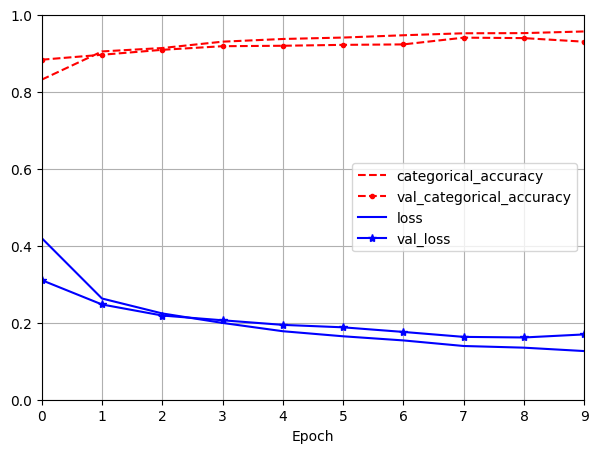

In [ ]:
plot()

In [ ]:
loss, categorical_accuracy = model.evaluate(test_dataset_efficientnet)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 [==============================] - 8s 186ms/step - loss: 0.1769 - categorical_accuracy: 0.9367


# <h2 style = "color: #35454F">Xception   </h2>

In [ ]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.xception import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_xception = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_xception = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_xception = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import Xception
Xception_model = Xception(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
Xception_model.trainable = False

x = Xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=Xception_model.input, outputs=predictions)
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])

# fitting
callbacks = get_callbacks('Xception')
history = model.fit(
    train_dataset_xception,
    epochs=10,
    validation_data=validation_dataset_xception,
    callbacks=callbacks
)

83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 0.4594 - categorical_accuracy: 0.8268
Epoch 1: val_loss improved from inf to 0.36849, saving model to model.Xception.h5
152/152 [==============================] - 43s 237ms/step - loss: 0.4594 - categorical_accuracy: 0.8268 - val_loss: 0.3685 - val_categorical_accuracy: 0.8773 - lr: 2.0000e-04
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.2674 - categorical_accuracy: 0.9053
Epoch 2: val_loss improved from 0.36849 to 0.27824, saving model to model.Xception.h5
152/152 [==============================] - 40s 258ms/step - loss: 0.2674 - categorical_accuracy: 0.9053 - val_loss: 0.2782 - val_categorical_accuracy: 0.9077 - lr: 2.0000e-04
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.2088 - categorical_accuracy: 0.9287
Epoch 3: val_loss did not improve from 0.27824
152/152 [==============================] - 29s

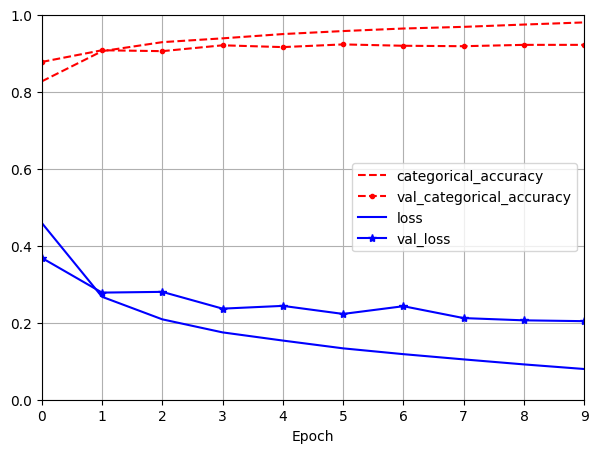

In [ ]:
plot()

In [ ]:
loss, categorical_accuracy = model.evaluate(test_dataset_xception)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 [==============================] - 10s 247ms/step - loss: 0.2132 - categorical_accuracy: 0.9237


In [ ]:
# here i  will make dataframe for all models_info

models_df = pd.DataFrame({"model-name":model_name, "Categorical_accuracy": CategoricalAccuracy , 'Loss': losses})
models_df = models_df.set_index('model-name')
models_df.sort_values("Loss", ascending = True)

,Categorical_accuracy,Loss
model-name,,
VGG16,0.948131,0.165281
EfficientNetV2S,0.936690,0.176903
ResNet50V2,0.950420,0.179775
MobileNetV2,0.937452,0.187402
Xception,0.923722,0.213164
DenseNet121,0.924485,0.213360
My_model,0.924485,0.268610


<div class= "alert alert-block alert-info">
             <b> The best model is "VGG16" </b>
</div>

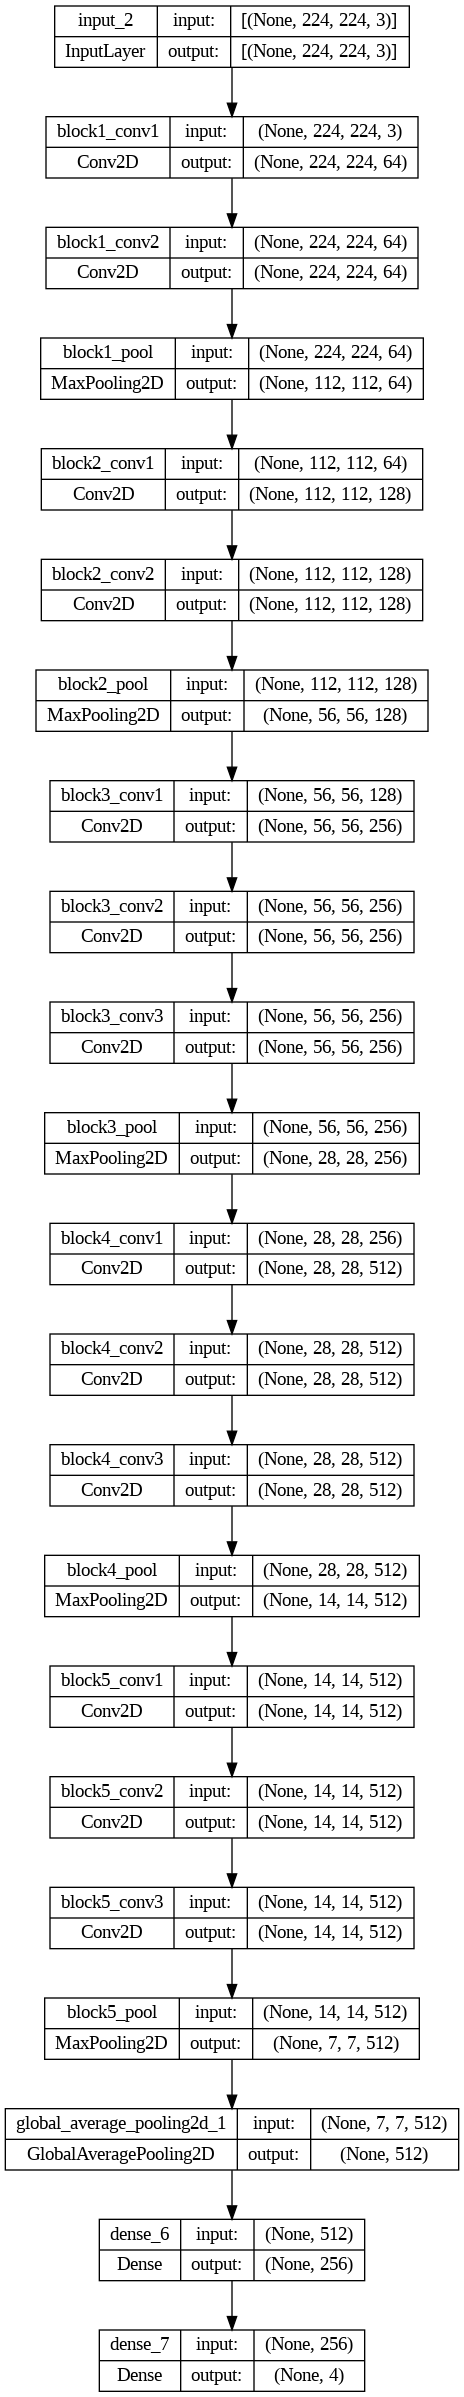

In [ ]:
best_model = keras.models.load_model('model.VGG16.h5')
tf.keras.utils.plot_model(best_model, show_shapes=True)

<hr>

# Fine-tuning

In [ ]:
vgg_tuning = keras.models.load_model('/content/drive/MyDrive/Brain Tumor MRI Dataset/model.VGG16.h5')

In [ ]:
for layer in vgg_tuning.layers[:17]:
    layer.trainable = False
# Set the last 5 layers to trainable
for layer in vgg_tuning.layers[17:]:
    layer.trainable = True

callbacks = get_callbacks('vgg_tuning')
history = vgg_tuning.fit(
    train_dataset_vgg16,
    epochs=10,
    validation_data=validation_dataset_vgg16,
    callbacks=callbacks
)

Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 0.1881 - categorical_accuracy: 0.9279
Epoch 1: val_loss improved from inf to 0.17271, saving model to model.vgg_tuning.h5
152/152 [==============================] - 304s 2s/step - loss: 0.1881 - categorical_accuracy: 0.9279 - val_loss: 0.1727 - val_categorical_accuracy: 0.9357 - lr: 0.0010
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.0925 - categorical_accuracy: 0.9675
Epoch 2: val_loss improved from 0.17271 to 0.15433, saving model to model.vgg_tuning.h5
152/152 [==============================] - 64s 416ms/step - loss: 0.0925 - categorical_accuracy: 0.9675 - val_loss: 0.1543 - val_categorical_accuracy: 0.9498 - lr: 0.0010
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.0546 - categorical_accuracy: 0.9817
Epoch 3: val_loss did not improve from 0.15433
152/152 [==============================] - 37s 237ms/step - loss: 0.0546 - categorical_accuracy: 0.9817 - val_loss: 0

In [ ]:
loss, categorical_accuracy = vgg_tuning.evaluate(test_dataset_vgg16)


41/41 [==============================] - 14s 340ms/step - loss: 0.0952 - categorical_accuracy: 0.9764


In [ ]:
y_true = np.argmax(y_true, axis=1)
y_pred = vgg_tuning.predict(test_dataset_vgg16)
y_pred = np.argmax(y_pred, axis=1)

41/41 [==============================] - 798s 19s/step


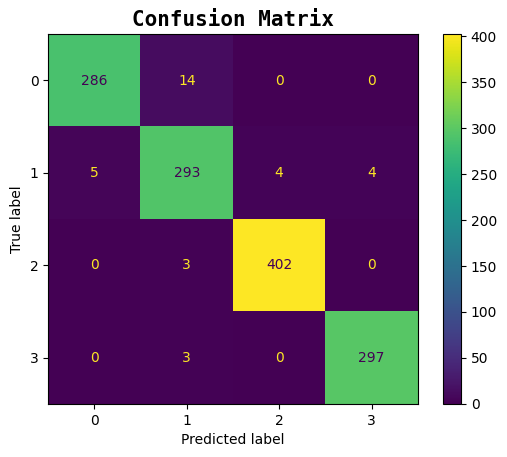

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true , y_pred)
plt.title("Confusion Matrix", fontname = "monospace", fontsize = 15, weight = "bold")
plt.show()

In [ ]:
print("\nClassification Report:\n")
print(Fore.BLUE + classification_report(y_true, y_pred, target_names = class_names, digits= 4))


Classification Report:

              precision    recall  f1-score   support

      glioma     0.9828    0.9533    0.9679       300
  meningioma     0.9361    0.9575    0.9467       306
     notumor     0.9901    0.9926    0.9914       405
   pituitary     0.9867    0.9900    0.9884       300

    accuracy                         0.9748      1311
   macro avg     0.9739    0.9734    0.9736      1311
weighted avg     0.9751    0.9748    0.9749      1311



<hr>